# 0. Imports

In [322]:
############## AUTORELOAD MAGIC ###################
%load_ext autoreload
%autoreload 2
###################################################

############## FUNDAMENTAL MODULES ################
import json
from PIL import Image
import os
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np
 ##################################################


############## TASK-SPECIFIC MODULES ##############
sys.path.append(os.path.join(os.getcwd(),"src"))
import embed_txtimg_pairs as etp
###################################################


############## DATA SCIENCE & ML MODULES ##########
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch
###################################################


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Load the training set (raw data)
dataset_directory = "/Users/onurdenizguler/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_v1"
train_jsonl_file = os.path.join(dataset_directory, "CT23_1A_checkworthy_multimodal_english_train.jsonl")

train_set = []
with open(train_jsonl_file, "r") as f:
    for line in f:
       train_set.append(json.loads(line))

Text(0.5, 1.0, 'Original image and tweet')

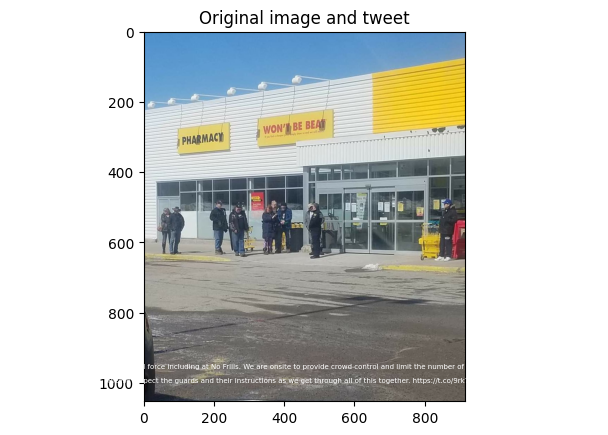

In [137]:
# Examine a single sample from the training set
sample = train_set[0]
tweet_id = sample["tweet_id"]
tweet_text = sample["tweet_text"]
tweet_url = sample["tweet_url"]
img_path = os.path.join(dataset_directory, sample["image_path"])
img = Image.open(img_path)

fig, ax = plt.subplots()
#fig.set_size_inches(15, 15)
ax.imshow(img)
ax.text(0.5, 0.05, tweet_text, transform=ax.transAxes,
        fontsize=5, ha='center', color='white')
plt.title("Original image and tweet")

# <font color="Crimson"> Use the model to embed a single sample from the train set

<font color="Black"> In this implementation we use the following model: "clip-vit-base-patch32". This model differs from the paper implementation in that it uses ViT instead of ResNet. https://huggingface.co/openai/clip-vit-base-patch32

In [ ]:
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

### <font color="Crimson"> Tokenize and embed the tweet

In [114]:
# Create tokens from the tweet text
inputs = tokenizer(tweet_text, return_tensors="pt").to(device)
print("Tokens: ", inputs)

# Embed the tokenized tweet as a single entity into a 512-dim space
text_emb = model.get_text_features(**inputs)
print("\nEmbedding shape: ", text_emb.shape)

Tokens:  {'input_ids': tensor([[49406,   581,  1027,   530, 20761,  2553,   533, 20009,  1476,  2869,
          2814,   536,   871,   936,  1900,   269,   649,   631, 37336,   531,
          4832,  4570,  3366,   537,  9973,   518,  2842,   539,  1047,   530,
           518,  2183,   536,  1504,  4302,   788,   269,  1474,  4916,   518,
         12810,   537,   911, 17040,   601,   649,   779,  1417,   615,   539,
           589,  1952,   269, 30901, 12441,   339,   269,  1320,   270,   280,
         21422,   278,   619,   342,   271,  3996, 49407]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='mps:0')}

Embedding shape:  torch.Size([1, 512])


### <font color="Crimson"> Process and embed the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image shape (width, height):  (914, 1053)
Resized image shape:  torch.Size([1, 3, 224, 224])


Text(0.5, 1.0, 'Image after processor transformation')

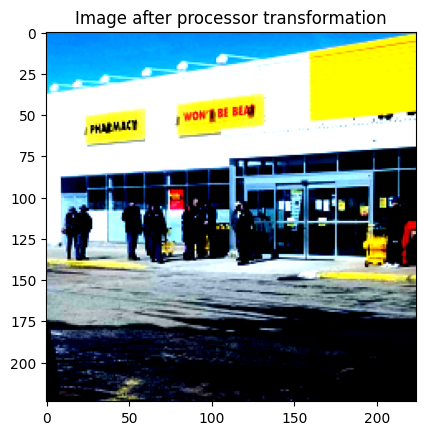

In [138]:
# Resize the image using the processor
image = processor(
    text=None,
    images=img,
    return_tensors='pt'
)['pixel_values'].to(device)
print("Original image shape (width, height): ", img.size)
print("Resized image shape: ", image.shape)

# Display the transformed image
tensor_image_to_display = copy.deepcopy(image)
tensor_image_to_display = tensor_image_to_display.to("cpu")
tensor_image_to_display = tensor_image_to_display.squeeze()
plt.imshow(tensor_image_to_display.permute(1, 2, 0))
plt.title("Image after processor transformation")

In [139]:
# Embed the transformed image
img_emb = model.get_image_features(image)
print("Image embedding shape: ", img_emb.shape)

Image embedding shape:  torch.Size([1, 512])


# <font color="ForestGreen"> Load all data from train/dev/test sets and embed them using CLIP

In [193]:
# Collect all train/dev/test tweets and images
train_jsonl_file = os.path.join(dataset_directory, "CT23_1A_checkworthy_multimodal_english_train.jsonl")
dev_jsonl_file = os.path.join(dataset_directory, "CT23_1A_checkworthy_multimodal_english_dev.jsonl")
test_jsonl_file = os.path.join(dataset_directory, "CT23_1A_checkworthy_multimodal_english_dev_test.jsonl")

train_set = train_set

dev_set = []
with open(dev_jsonl_file, "r") as f:
    for line in f:
       dev_set.append(json.loads(line))

test_set = []
with open(test_jsonl_file, "r") as f:
    for line in f:
       test_set.append(json.loads(line))

texts_train = []
imgs_train = []
for sample in train_set:
    tweet_text = sample["tweet_text"]
    img_path = os.path.join(dataset_directory, sample["image_path"])
    img = Image.open(img_path)
    texts_train.append(tweet_text)
    imgs_train.append(img)

texts_dev = []
imgs_dev = []
for sample in dev_set:
    tweet_text = sample["tweet_text"]
    img_path = os.path.join(dataset_directory, sample["image_path"])
    img = Image.open(img_path)
    texts_dev.append(tweet_text)
    imgs_dev.append(img)

texts_test = []
imgs_test = []
for sample in test_set:
    tweet_text = sample["tweet_text"]
    img_path = os.path.join(dataset_directory, sample["image_path"])
    img = Image.open(img_path)
    texts_test.append(tweet_text)
    imgs_test.append(img)

In [194]:
print("Sizes of train/test/dev txt and img arrays respectively: ")
print(len(texts_train), len(imgs_train))
print(len(texts_dev), len(imgs_dev))
print(len(texts_test), len(imgs_test))

Sizes of train/test/dev txt and img arrays respectively: 
2299 2299
256 256
525 525


In [217]:
# Embed data
testset_embeddings = {
    "txt" : None,
    "img": None
}
a = etp.embed_split(texts_test, imgs_test, batch_size = 256)
#testset_embeddings["txt"], testset_embeddings["img"] = etp.embed_split(texts_test, imgs_test, batch_size = 256)

  0%|          | 0/3 [00:00<?, ?it/s]


In [312]:
# Determine the number of samples having longer than 77 tokens
tokens_train = tokenizer(texts_train, padding=True, return_tensors="pt")["input_ids"]
tokens_dev = tokenizer(texts_dev, padding=True, return_tensors="pt")["input_ids"]
tokens_test = tokenizer(texts_test, padding=True, return_tensors="pt")["input_ids"]

In [378]:
excess_tokens_train = []
for idx, item in enumerate(tokens_train):
    seq_length = (item == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
    if seq_length >  77:
        excess_tokens_train.append(seq_length.item() - 77) # record how many tokens would be truncated
excess_tokens_train = np.sort(np.array(excess_tokens_train))

excess_tokens_dev = []
for idx, item in enumerate(tokens_dev):
    seq_length = (item == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
    if seq_length >  77:
        excess_tokens_dev.append(seq_length.item() - 77) # record how many tokens would be truncated
excess_tokens_dev= np.sort(np.array(excess_tokens_dev))

excess_tokens_test = []
for idx, item in enumerate(tokens_test):
    seq_length = (item == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
    if seq_length >  77:
        excess_tokens_test.append(seq_length.item() - 77) # record how many tokens would be truncated
excess_tokens_test= np.sort(np.array(excess_tokens_test))

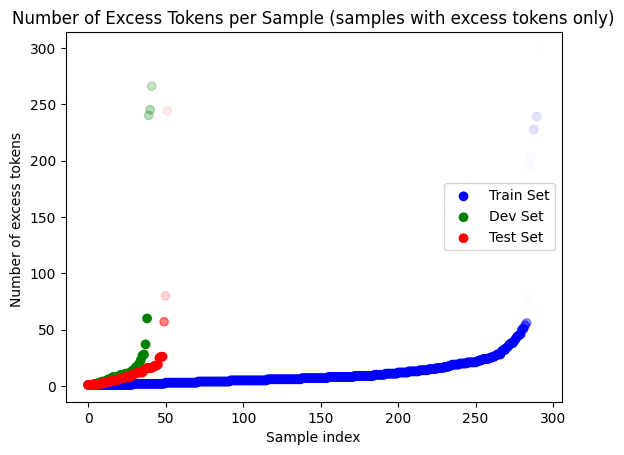

In [380]:
from scipy import stats
data = [excess_tokens_train, excess_tokens_dev, excess_tokens_test]

# define the colors for each dataset
colors = ['blue', 'green', 'red']
labels = ['Train Set', 'Dev Set', 'Test Set']

# create a figure and axis object
fig, ax = plt.subplots()

# loop through the datasets and plot them as scatter plots
for i in range(len(data)):
    # calculate the density of points in the current dataset
    kde = stats.gaussian_kde(data[i])
    density = kde(data[i])*600
    density[density > 1] = 1
    
    # create a scatter plot for the current dataset, using the density as the alpha value to make the colors darker where there are more points
    ax.scatter(range(len(data[i])), data[i], color=colors[i], alpha=density**2, label=labels[i])

# set axis labels and title
ax.set_xlabel('Sample index')
ax.set_ylabel('Number of excess tokens ')
ax.set_title('Number of Excess Tokens per Sample (samples with excess tokens only)')

# add legend
ax.legend()

# show the plot

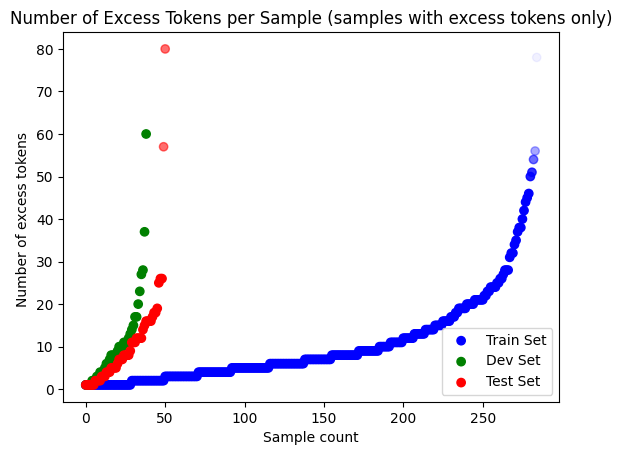

In [381]:
from scipy import stats
# Remove outliers from the data
excess_tokens_train_summary = excess_tokens_train[excess_tokens_train<150]
excess_tokens_dev_summary = excess_tokens_dev[excess_tokens_dev<150]
excess_tokens_test_summary = excess_tokens_test[excess_tokens_test<150]
data = [excess_tokens_train_summary, excess_tokens_dev_summary, excess_tokens_test_summary]

# define the colors for each dataset
colors = ['blue', 'green', 'red']
labels = ['Train Set', 'Dev Set', 'Test Set']

# create a figure and axis object
fig, ax = plt.subplots()

# loop through the datasets and plot them as scatter plots
for i in range(len(data)):
    # calculate the density of points in the current dataset
    kde = stats.gaussian_kde(data[i])
    density = kde(data[i])*600
    density[density > 1] = 1
    
    # create a scatter plot for the current dataset, using the density as the alpha value to make the colors darker where there are more points
    ax.scatter(range(len(data[i])), data[i], color=colors[i], alpha=density**2, label=labels[i])

# set axis labels and title
ax.set_xlabel('Sample count')
ax.set_ylabel('Number of excess tokens ')
ax.set_title('Number of Excess Tokens per Sample (samples with excess tokens only)')

# add legend
ax.legend()

# show the plot

In [386]:
# Find mean-median num. of tokens to be truncated 
all_excess_tokens =  np.concatenate((excess_tokens_train, excess_tokens_dev))
all_excess_tokens = np.concatenate((all_excess_tokens, excess_tokens_test))
print(np.mean(all_excess_tokens))
print(np.median(all_excess_tokens))

17.230569948186528
7.0


# Miscallenous

##  Display each sample (image + printed tweet on image)

/var/folders/01/g3_km85s2szfllv46j0d2vvw0000gn/T/ipykernel_51229/1779253.py:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)


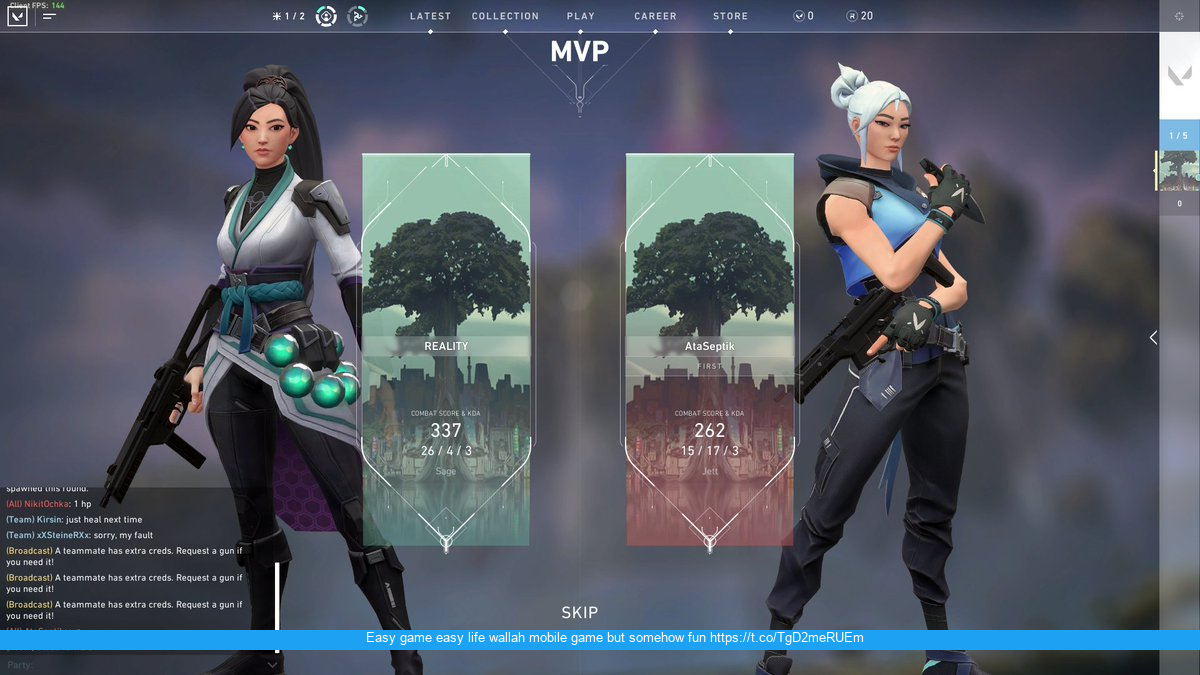

In [377]:
from PIL import Image, ImageDraw, ImageFont

# Open the image file
image = Image.open(img_path)

# Get the image dimensions
width, height = image.size

# Set the font size based on the height of the image
font_size = int(height / 50)

# Create a new ImageDraw object
draw = ImageDraw.Draw(image)

# Choose a font for the text
import platform
if platform.system() == "Darwin":
    font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
else:
    font_path = Arial.ttf
font = ImageFont.truetype(font_path, font_size)

# Define the text to be displayed
text = tweet_text.replace("\n", "")

# Get the width and height of the text
text_width, text_height = draw.textsize(text)

# Calculate the position of the text
x = int((width - text_width) / 2)
y = int(height - text_height - (height / 20))

# Draw a black rectangle with 50% opacity underneath the text
rect_height = int(font_size * 1.5)
rect_y = y + rect_height
draw.rectangle((0, rect_y, width, y), fill=(29, 161, 242, 128))

# Choose a visible color for the text
text_color = (255, 255, 255)

# Draw the text on the image
draw.text((x, y), text, font=font, fill=text_color)

# Display the image
display(image)